# Detect room occupancy

train pymc model to detect room occupancy
run pymc model to detect room occupancy

model will use "Temperature","Humidity","Light","CO2","HumidityRatio"
to declare "Occupancy"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import numpy as np
import xarray as xr
import lux 


In [2]:
import pandas as pd
import os


In [3]:
import pytensor.tensor as pt

In [4]:
import itertools


In [5]:
from pymc.gp.util import plot_gp_dist

In [6]:
from sklearn.preprocessing import MinMaxScaler


In [7]:
import pymc.sampling_jax
def sample(model, target_accept=0.8):
    """ Simple sampling function so we can keep the same settings
    """
    with model:
        idata = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000, target_accept=target_accept)
    print("Divergences:", int(idata.sample_stats.diverging.sum().values))
    return idata


In [8]:

file_path = "datatraining.txt"

df = pd.read_csv(file_path)
df

date  Temperature  Humidity  Light         CO2  \
1     2015-02-04 17:51:00        23.18   27.2720  426.0  721.250000   
2     2015-02-04 17:51:59        23.15   27.2675  429.5  714.000000   
3     2015-02-04 17:53:00        23.15   27.2450  426.0  713.500000   
4     2015-02-04 17:54:00        23.15   27.2000  426.0  708.250000   
5     2015-02-04 17:55:00        23.10   27.2000  426.0  704.500000   
...                   ...          ...       ...    ...         ...   
8139  2015-02-10 09:29:00        21.05   36.0975  433.0  787.250000   
8140  2015-02-10 09:29:59        21.05   35.9950  433.0  789.500000   
8141  2015-02-10 09:30:59        21.10   36.0950  433.0  798.500000   
8142  2015-02-10 09:32:00        21.10   36.2600  433.0  820.333333   
8143  2015-02-10 09:33:00        21.10   36.2000  447.0  821.000000   

      HumidityRatio  Occupancy  
1          0.004793          1  
2          0.004783          1  
3          0.004779          1  
4          0.004772          1  
5          0.004757          1  
...             ...        ...  
8139       0.005579          1  
8140       0.005563          1  
8141       0.005596          1  
8142       0.005621          1  
8143       0.005612          1  

[8143 rows x 7 columns]

In [9]:
df['date'] = pd.to_datetime(df['date'])

<Axes: xlabel='date'>

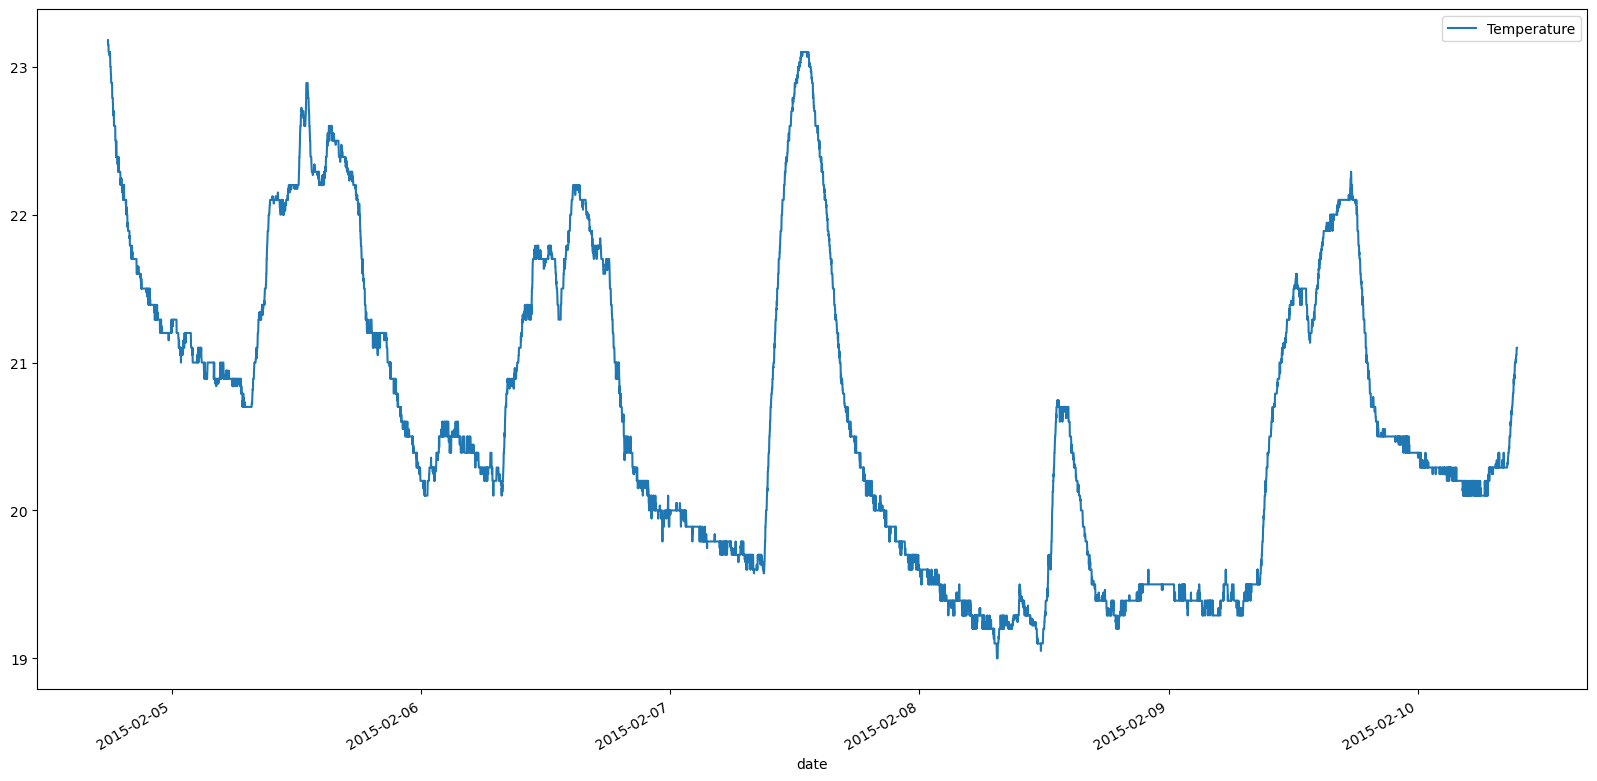

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)#, projection='polar')

df[['date', 'Temperature']].plot(x='date', y='Temperature', figsize=(20, 10), ax=ax)



In [11]:
xr_data = xr.DataArray(df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']]
             , dims=['time', 'measure'], coords={'time': df['date'], 
                                                 'measure': ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']})

In [432]:


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(xr_data)

scaled_xr_data = xr.DataArray(scaled_data, dims=xr_data.dims, coords=xr_data.coords)
time_float_var = xr.DataArray(data=scaled_xr_data['time'].astype(np.float64).values[:,None], 
             coords={'time': scaled_xr_data['time'], 'measure' : ("measure", ["time_float"])}, 
             dims=['time', 'measure'])
#time_float_var, _ = pd.factorize(scaled_xr_data['time']) # TODO: change name, not float time_float_var-time_float_var.min()
time_float_var.values = np.atleast_2d( np.arange(len(time_float_var))).T
scaled_xr_data = xr.concat([scaled_xr_data, time_float_var], dim='measure')
#train_xr_data['time'].astype(np.float64)

scaled_xr_data = scaled_xr_data.roll(measure=1, roll_coords=True) #make the float time the first dimension
#scaled_xr_data =scaled_xr_data.sel(measure=['Occupancy',  'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'time_float'])
scaled_xr_data=scaled_xr_data.resample(time='60T').mean()
scaled_xr_data

<xarray.DataArray (time: 137, measure: 7)>
array([[4.00000000e+00, 9.86975013e-01, 4.68231087e-01, 2.73729971e-01,
        1.81391511e-01, 5.50756543e-01, 1.00000000e+00],
       [3.85000000e+01, 8.67590377e-01, 4.75730373e-01, 3.16070274e-02,
        1.50380800e-01, 5.20778209e-01, 1.16666667e-01],
       [9.90000000e+01, 7.33266661e-01, 4.66469679e-01, 0.00000000e+00,
        9.88079264e-02, 4.70329363e-01, 0.00000000e+00],
       [1.59000000e+02, 6.40377909e-01, 4.47450809e-01, 0.00000000e+00,
        6.70264723e-02, 4.24561983e-01, 0.00000000e+00],
       [2.18500000e+02, 5.93045587e-01, 4.09730448e-01, 0.00000000e+00,
        5.01616037e-02, 3.75493613e-01, 0.00000000e+00],
       [2.79000000e+02, 5.56978325e-01, 3.99938449e-01, 0.00000000e+00,
        3.96861834e-02, 3.56399632e-01, 0.00000000e+00],
       [3.39000000e+02, 5.27147028e-01, 3.87650547e-01, 0.00000000e+00,
        3.31133064e-02, 3.36940997e-01, 0.00000000e+00],
       [3.98500000e+02, 5.26508506e-01, 3.82240101e-01, 0.00000000e+00,
        2.54508570e-02, 3.31775346e-01, 0.00000000e+00],
       [4.59000000e+02, 5.16445734e-01, 3.76854391e-01, 0.00000000e+00,
        1.92977428e-02, 3.24147056e-01, 0.00000000e+00],
       [5.19000000e+02, 4.85564837e-01, 3.66103463e-01, 0.00000000e+00,
        1.70645421e-02, 3.06186159e-01, 0.00000000e+00],
...
       [7.59850000e+03, 3.16188198e-01, 7.25543512e-01, 0.00000000e+00,
        4.61197930e-02, 5.76867228e-01, 0.00000000e+00],
       [7.65900000e+03, 3.08213716e-01, 7.23846789e-01, 0.00000000e+00,
        3.38547546e-02, 5.72728015e-01, 0.00000000e+00],
       [7.71900000e+03, 3.05328035e-01, 7.21455479e-01, 0.00000000e+00,
        2.76121967e-02, 5.69684779e-01, 0.00000000e+00],
       [7.77850000e+03, 2.95125598e-01, 7.21895060e-01, 0.00000000e+00,
        2.39345333e-02, 5.66691205e-01, 0.00000000e+00],
       [7.83900000e+03, 2.77015191e-01, 7.24949578e-01, 0.00000000e+00,
        2.09194160e-02, 5.63355163e-01, 0.00000000e+00],
       [7.89900000e+03, 2.72957046e-01, 7.27959378e-01, 0.00000000e+00,
        2.13190950e-02, 5.64622735e-01, 0.00000000e+00],
       [7.95850000e+03, 2.75023259e-01, 7.30813499e-01, 0.00000000e+00,
        2.24732236e-02, 5.67782313e-01, 0.00000000e+00],
       [8.01900000e+03, 3.09743248e-01, 7.28149862e-01, 0.00000000e+00,
        2.38203342e-02, 5.76996845e-01, 0.00000000e+00],
       [8.07900000e+03, 3.24014003e-01, 7.40833335e-01, 1.01965283e-01,
        3.44866170e-02, 5.92969369e-01, 3.38983051e-01],
       [8.12550000e+03, 4.50133103e-01, 8.26303848e-01, 2.77687255e-01,
        1.61289907e-01, 7.13914414e-01, 1.00000000e+00]])
Coordinates:
  * measure  (measure) <U13 'time_float' 'Temperature' ... 'Occupancy'
  * time     (time) datetime64[ns] 2015-02-04T17:00:00 ... 2015-02-10T09:00:00

In [435]:
scaled_xr_data.sel(measure='time_float')

<xarray.DataArray (time: 137)>
array([4.0000e+00, 3.8500e+01, 9.9000e+01, 1.5900e+02, 2.1850e+02,
       2.7900e+02, 3.3900e+02, 3.9850e+02, 4.5900e+02, 5.1900e+02,
       5.7850e+02, 6.3900e+02, 6.9900e+02, 7.5850e+02, 8.1900e+02,
       8.7900e+02, 9.3850e+02, 9.9900e+02, 1.0590e+03, 1.1185e+03,
       1.1790e+03, 1.2390e+03, 1.2985e+03, 1.3590e+03, 1.4190e+03,
       1.4785e+03, 1.5390e+03, 1.5990e+03, 1.6585e+03, 1.7190e+03,
       1.7790e+03, 1.8385e+03, 1.8990e+03, 1.9590e+03, 2.0185e+03,
       2.0790e+03, 2.1390e+03, 2.1985e+03, 2.2590e+03, 2.3190e+03,
       2.3785e+03, 2.4390e+03, 2.4990e+03, 2.5585e+03, 2.6190e+03,
       2.6790e+03, 2.7385e+03, 2.7990e+03, 2.8590e+03, 2.9185e+03,
       2.9790e+03, 3.0390e+03, 3.0985e+03, 3.1590e+03, 3.2190e+03,
       3.2785e+03, 3.3390e+03, 3.3990e+03, 3.4585e+03, 3.5190e+03,
       3.5790e+03, 3.6385e+03, 3.6990e+03, 3.7590e+03, 3.8185e+03,
       3.8790e+03, 3.9390e+03, 3.9985e+03, 4.0590e+03, 4.1190e+03,
       4.1785e+03, 4.2390e+03, 4.2990e+03, 4.3585e+03, 4.4190e+03,
       4.4790e+03, 4.5385e+03, 4.5990e+03, 4.6590e+03, 4.7185e+03,
       4.7790e+03, 4.8390e+03, 4.8985e+03, 4.9590e+03, 5.0190e+03,
       5.0785e+03, 5.1390e+03, 5.1990e+03, 5.2585e+03, 5.3190e+03,
       5.3790e+03, 5.4385e+03, 5.4990e+03, 5.5590e+03, 5.6185e+03,
       5.6790e+03, 5.7390e+03, 5.7985e+03, 5.8590e+03, 5.9190e+03,
       5.9785e+03, 6.0390e+03, 6.0990e+03, 6.1585e+03, 6.2190e+03,
       6.2790e+03, 6.3385e+03, 6.3990e+03, 6.4590e+03, 6.5185e+03,
       6.5790e+03, 6.6390e+03, 6.6985e+03, 6.7590e+03, 6.8190e+03,
       6.8785e+03, 6.9390e+03, 6.9990e+03, 7.0585e+03, 7.1190e+03,
       7.1790e+03, 7.2385e+03, 7.2990e+03, 7.3590e+03, 7.4185e+03,
       7.4790e+03, 7.5390e+03, 7.5985e+03, 7.6590e+03, 7.7190e+03,
       7.7785e+03, 7.8390e+03, 7.8990e+03, 7.9585e+03, 8.0190e+03,
       8.0790e+03, 8.1255e+03])
Coordinates:
    measure  <U13 'time_float'
  * time     (time) datetime64[ns] 2015-02-04T17:00:00 ... 2015-02-10T09:00:00

In [299]:
time_float_var.values = np.atleast_2d( np.arange(len(time_float_var))).T

In [300]:
training_split = .3
train_test = np.random.choice(["Train", "Test"], size=len(scaled_xr_data['time']), p=[training_split, 1-training_split])
scaled_xr_data.coords['train_test'] = ('time', train_test)

In [301]:
time_occupancy = scaled_xr_data.sel(measure=['time_float','Occupancy']).drop_vars('train_test')
time_occupancy

<xarray.DataArray (time: 137, measure: 2)>
array([[4.00000000e+00, 1.00000000e+00],
       [3.85000000e+01, 1.16666667e-01],
       [9.90000000e+01, 0.00000000e+00],
       [1.59000000e+02, 0.00000000e+00],
       [2.18500000e+02, 0.00000000e+00],
       [2.79000000e+02, 0.00000000e+00],
       [3.39000000e+02, 0.00000000e+00],
       [3.98500000e+02, 0.00000000e+00],
       [4.59000000e+02, 0.00000000e+00],
       [5.19000000e+02, 0.00000000e+00],
       [5.78500000e+02, 0.00000000e+00],
       [6.39000000e+02, 0.00000000e+00],
       [6.99000000e+02, 0.00000000e+00],
       [7.58500000e+02, 0.00000000e+00],
       [8.19000000e+02, 3.27868852e-01],
       [8.79000000e+02, 9.83050847e-01],
       [9.38500000e+02, 1.00000000e+00],
       [9.99000000e+02, 9.34426230e-01],
       [1.05900000e+03, 1.00000000e+00],
       [1.11850000e+03, 7.50000000e-01],
...
       [6.99900000e+03, 1.00000000e+00],
       [7.05850000e+03, 1.00000000e+00],
       [7.11900000e+03, 1.00000000e+00],
       [7.17900000e+03, 1.00000000e+00],
       [7.23850000e+03, 8.33333333e-02],
       [7.29900000e+03, 0.00000000e+00],
       [7.35900000e+03, 0.00000000e+00],
       [7.41850000e+03, 0.00000000e+00],
       [7.47900000e+03, 0.00000000e+00],
       [7.53900000e+03, 0.00000000e+00],
       [7.59850000e+03, 0.00000000e+00],
       [7.65900000e+03, 0.00000000e+00],
       [7.71900000e+03, 0.00000000e+00],
       [7.77850000e+03, 0.00000000e+00],
       [7.83900000e+03, 0.00000000e+00],
       [7.89900000e+03, 0.00000000e+00],
       [7.95850000e+03, 0.00000000e+00],
       [8.01900000e+03, 0.00000000e+00],
       [8.07900000e+03, 3.38983051e-01],
       [8.12550000e+03, 1.00000000e+00]])
Coordinates:
  * measure  (measure) <U13 'time_float' 'Occupancy'
  * time     (time) datetime64[ns] 2015-02-04T17:00:00 ... 2015-02-10T09:00:00

In [303]:
train_data = scaled_xr_data.where(scaled_xr_data['train_test'] == 'Train', drop=True)
test_data = scaled_xr_data.where(scaled_xr_data['train_test'] == 'Test', drop=True)
display(train_data, test_data)

<xarray.DataArray (time: 41, measure: 7)>
array([[0.00000000e+00, 7.33266661e-01, 4.66469679e-01, 0.00000000e+00,
        9.88079264e-02, 4.70329363e-01, 9.90000000e+01],
       [0.00000000e+00, 4.40291069e-01, 2.81879415e-01, 0.00000000e+00,
        2.37161965e-02, 2.18637697e-01, 7.58500000e+02],
       [1.00000000e+00, 7.08579213e-01, 3.96290337e-01, 3.08348602e-01,
        3.34117713e-01, 3.95433161e-01, 9.38500000e+02],
       [9.34426230e-01, 7.35489058e-01, 4.31808909e-01, 2.96574127e-01,
        3.82194061e-01, 4.37210884e-01, 9.99000000e+02],
       [7.50000000e-01, 8.43942717e-01, 4.48025229e-01, 3.69150499e-01,
        4.13103306e-01, 4.85558922e-01, 1.11850000e+03],
       [1.14754098e-01, 8.26986430e-01, 4.16918091e-01, 2.05541047e-01,
        3.05985564e-01, 4.49492934e-01, 1.17900000e+03],
       [1.00000000e+00, 7.66357824e-01, 3.60619026e-01, 2.80340591e-01,
        3.26850538e-01, 3.76593294e-01, 1.41900000e+03],
       [8.33333333e-02, 6.13177831e-01, 2.80221875e-01, 2.08881224e-02,
        1.95310056e-01, 2.59795837e-01, 1.47850000e+03],
       [0.00000000e+00, 2.84011164e-01, 1.92504439e-01, 0.00000000e+00,
        1.95428679e-02, 1.04800960e-01, 1.83850000e+03],
       [0.00000000e+00, 3.26398149e-01, 1.58866241e-01, 0.00000000e+00,
        1.61203454e-02, 8.43402063e-02, 1.89900000e+03],
...
       [0.00000000e+00, 3.64149974e-01, 4.25915593e-01, 6.20143880e-02,
        5.62891243e-03, 3.27831687e-01, 5.55900000e+03],
       [0.00000000e+00, 9.53085719e-02, 4.49117504e-01, 0.00000000e+00,
        3.51212596e-02, 2.77112116e-01, 6.27900000e+03],
       [0.00000000e+00, 1.04431920e-01, 4.47180602e-01, 0.00000000e+00,
        3.05511337e-02, 2.77859365e-01, 6.45900000e+03],
       [1.00000000e+00, 5.43710972e-01, 7.35405212e-01, 3.06443893e-01,
        6.20910686e-01, 6.63932448e-01, 6.81900000e+03],
       [6.22950820e-01, 5.54896462e-01, 7.28310456e-01, 1.87877016e-01,
        4.69319007e-01, 6.61299082e-01, 6.93900000e+03],
       [1.00000000e+00, 7.34142547e-01, 9.83418363e-01, 2.83956583e-01,
        9.66378266e-01, 9.75163519e-01, 7.11900000e+03],
       [8.33333333e-02, 6.25764221e-01, 9.02886728e-01, 2.06743551e-02,
        7.05271890e-01, 8.52901441e-01, 7.23850000e+03],
       [0.00000000e+00, 4.31095903e-01, 8.46643426e-01, 0.00000000e+00,
        4.52558447e-01, 7.25141471e-01, 7.29900000e+03],
       [0.00000000e+00, 3.63480929e-01, 7.97273691e-01, 0.00000000e+00,
        2.86105786e-01, 6.56328560e-01, 7.35900000e+03],
       [0.00000000e+00, 2.75023259e-01, 7.30813499e-01, 0.00000000e+00,
        2.24732236e-02, 5.67782313e-01, 7.95850000e+03]])
Coordinates:
  * measure     (measure) <U13 'Occupancy' 'Temperature' ... 'time_float'
  * time        (time) datetime64[ns] 2015-02-04T19:00:00 ... 2015-02-10T06:0...
    train_test  (time) <U5 'Train' 'Train' 'Train' ... 'Train' 'Train' 'Train'

<xarray.DataArray (time: 96, measure: 7)>
array([[1.00000000e+00, 9.86975013e-01, 4.68231087e-01, 2.73729971e-01,
        1.81391511e-01, 5.50756543e-01, 4.00000000e+00],
       [1.16666667e-01, 8.67590377e-01, 4.75730373e-01, 3.16070274e-02,
        1.50380800e-01, 5.20778209e-01, 3.85000000e+01],
       [0.00000000e+00, 6.40377909e-01, 4.47450809e-01, 0.00000000e+00,
        6.70264723e-02, 4.24561983e-01, 1.59000000e+02],
       [0.00000000e+00, 5.93045587e-01, 4.09730448e-01, 0.00000000e+00,
        5.01616037e-02, 3.75493613e-01, 2.18500000e+02],
       [0.00000000e+00, 5.56978325e-01, 3.99938449e-01, 0.00000000e+00,
        3.96861834e-02, 3.56399632e-01, 2.79000000e+02],
       [0.00000000e+00, 5.27147028e-01, 3.87650547e-01, 0.00000000e+00,
        3.31133064e-02, 3.36940997e-01, 3.39000000e+02],
       [0.00000000e+00, 5.26508506e-01, 3.82240101e-01, 0.00000000e+00,
        2.54508570e-02, 3.31775346e-01, 3.98500000e+02],
       [0.00000000e+00, 5.16445734e-01, 3.76854391e-01, 0.00000000e+00,
        1.92977428e-02, 3.24147056e-01, 4.59000000e+02],
       [0.00000000e+00, 4.85564837e-01, 3.66103463e-01, 0.00000000e+00,
        1.70645421e-02, 3.06186159e-01, 5.19000000e+02],
       [0.00000000e+00, 4.70866560e-01, 3.54770862e-01, 0.00000000e+00,
        1.83781182e-02, 2.92057768e-01, 5.78500000e+02],
...
       [0.00000000e+00, 3.34320006e-01, 7.24832431e-01, 0.00000000e+00,
        6.89505057e-02, 5.82296406e-01, 7.53900000e+03],
       [0.00000000e+00, 3.16188198e-01, 7.25543512e-01, 0.00000000e+00,
        4.61197930e-02, 5.76867228e-01, 7.59850000e+03],
       [0.00000000e+00, 3.08213716e-01, 7.23846789e-01, 0.00000000e+00,
        3.38547546e-02, 5.72728015e-01, 7.65900000e+03],
       [0.00000000e+00, 3.05328035e-01, 7.21455479e-01, 0.00000000e+00,
        2.76121967e-02, 5.69684779e-01, 7.71900000e+03],
       [0.00000000e+00, 2.95125598e-01, 7.21895060e-01, 0.00000000e+00,
        2.39345333e-02, 5.66691205e-01, 7.77850000e+03],
       [0.00000000e+00, 2.77015191e-01, 7.24949578e-01, 0.00000000e+00,
        2.09194160e-02, 5.63355163e-01, 7.83900000e+03],
       [0.00000000e+00, 2.72957046e-01, 7.27959378e-01, 0.00000000e+00,
        2.13190950e-02, 5.64622735e-01, 7.89900000e+03],
       [0.00000000e+00, 3.09743248e-01, 7.28149862e-01, 0.00000000e+00,
        2.38203342e-02, 5.76996845e-01, 8.01900000e+03],
       [3.38983051e-01, 3.24014003e-01, 7.40833335e-01, 1.01965283e-01,
        3.44866170e-02, 5.92969369e-01, 8.07900000e+03],
       [1.00000000e+00, 4.50133103e-01, 8.26303848e-01, 2.77687255e-01,
        1.61289907e-01, 7.13914414e-01, 8.12550000e+03]])
Coordinates:
  * measure     (measure) <U13 'Occupancy' 'Temperature' ... 'time_float'
  * time        (time) datetime64[ns] 2015-02-04T17:00:00 ... 2015-02-10T09:0...
    train_test  (time) <U5 'Test' 'Test' 'Test' 'Test' ... 'Test' 'Test' 'Test'

In [304]:
train_dataset = xr.Dataset({'training':train_data.drop_vars(['train_test']).sel(
    measure=['time_float', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'])})

test_dataset = xr.Dataset({'testing':test_data.drop_vars(['train_test']).sel(
    measure=['time_float', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'])})
'''train_dataArray= train_dataset.to_stacked_array(new_dim='stacked_measure', 
                                                sample_dims=['time'], 
                                                variable_dim="model_use", 
                                                name='stacked_training')
train_dataArray

test_dataArray= test_dataset.to_stacked_array(new_dim='stacked_measure', 
                                              sample_dims=['time'], 
                                              variable_dim="model_use", 
                                              name='stacked_testing')  
test_dataArray'''

'train_dataArray= train_dataset.to_stacked_array(new_dim=\'stacked_measure\', \n                                                sample_dims=[\'time\'], \n                                                variable_dim="model_use", \n                                                name=\'stacked_training\')\ntrain_dataArray\n\ntest_dataArray= test_dataset.to_stacked_array(new_dim=\'stacked_measure\', \n                                              sample_dims=[\'time\'], \n                                              variable_dim="model_use", \n                                              name=\'stacked_testing\')  \ntest_dataArray'

In [305]:
'''measure_codes, measure_uniques = pd.factorize(train_dataArray['measure'].values)
measure_codes, measure_uniques


time_values = train_dataset['time'].values
measure_values = measure_codes

cross_product = np.array([[i,j] for i,j in itertools.product(time_values, measure_values)])
long_time_occupancy_train=time_occupancy.sel(time=cross_product[:,0])

long_time_occupancy_train=long_time_occupancy_train.to_dataset(name="float_time").drop_vars("measure")
long_time_occupancy_train['measure_codes'] = cross_product[:,1]
display(long_time_occupancy_train)

train_dataset. sel( time=cross_product[:,0], measure = measure_uniques[cross_product[:,1]] )'''


'measure_codes, measure_uniques = pd.factorize(train_dataArray[\'measure\'].values)\nmeasure_codes, measure_uniques\n\n\ntime_values = train_dataset[\'time\'].values\nmeasure_values = measure_codes\n\ncross_product = np.array([[i,j] for i,j in itertools.product(time_values, measure_values)])\nlong_time_occupancy_train=time_occupancy.sel(time=cross_product[:,0])\n\nlong_time_occupancy_train=long_time_occupancy_train.to_dataset(name="float_time").drop_vars("measure")\nlong_time_occupancy_train[\'measure_codes\'] = cross_product[:,1]\ndisplay(long_time_occupancy_train)\n\ntrain_dataset. sel( time=cross_product[:,0], measure = measure_uniques[cross_product[:,1]] )'

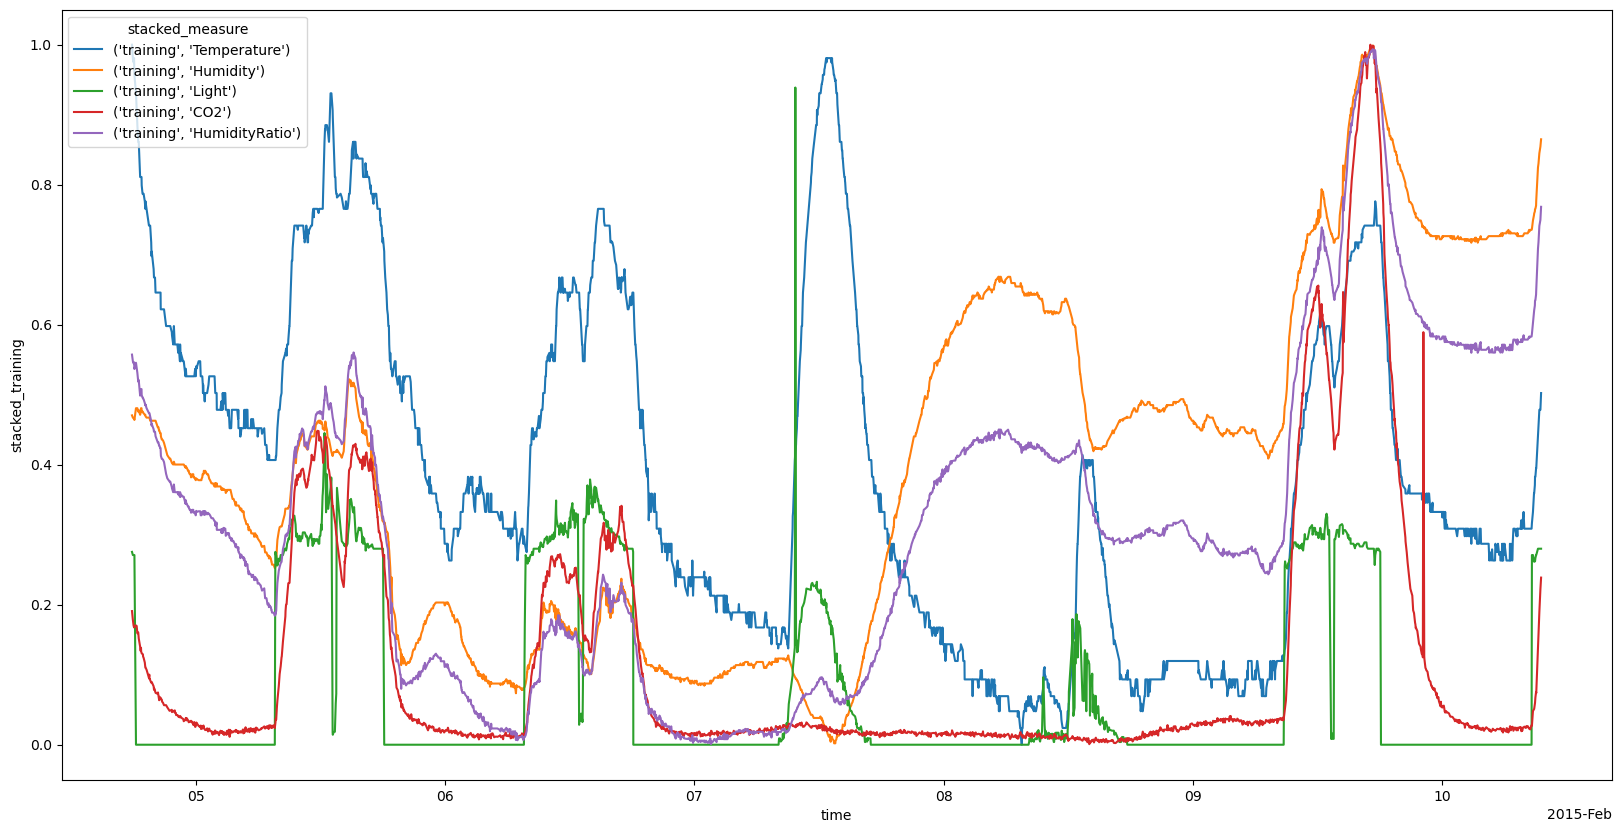

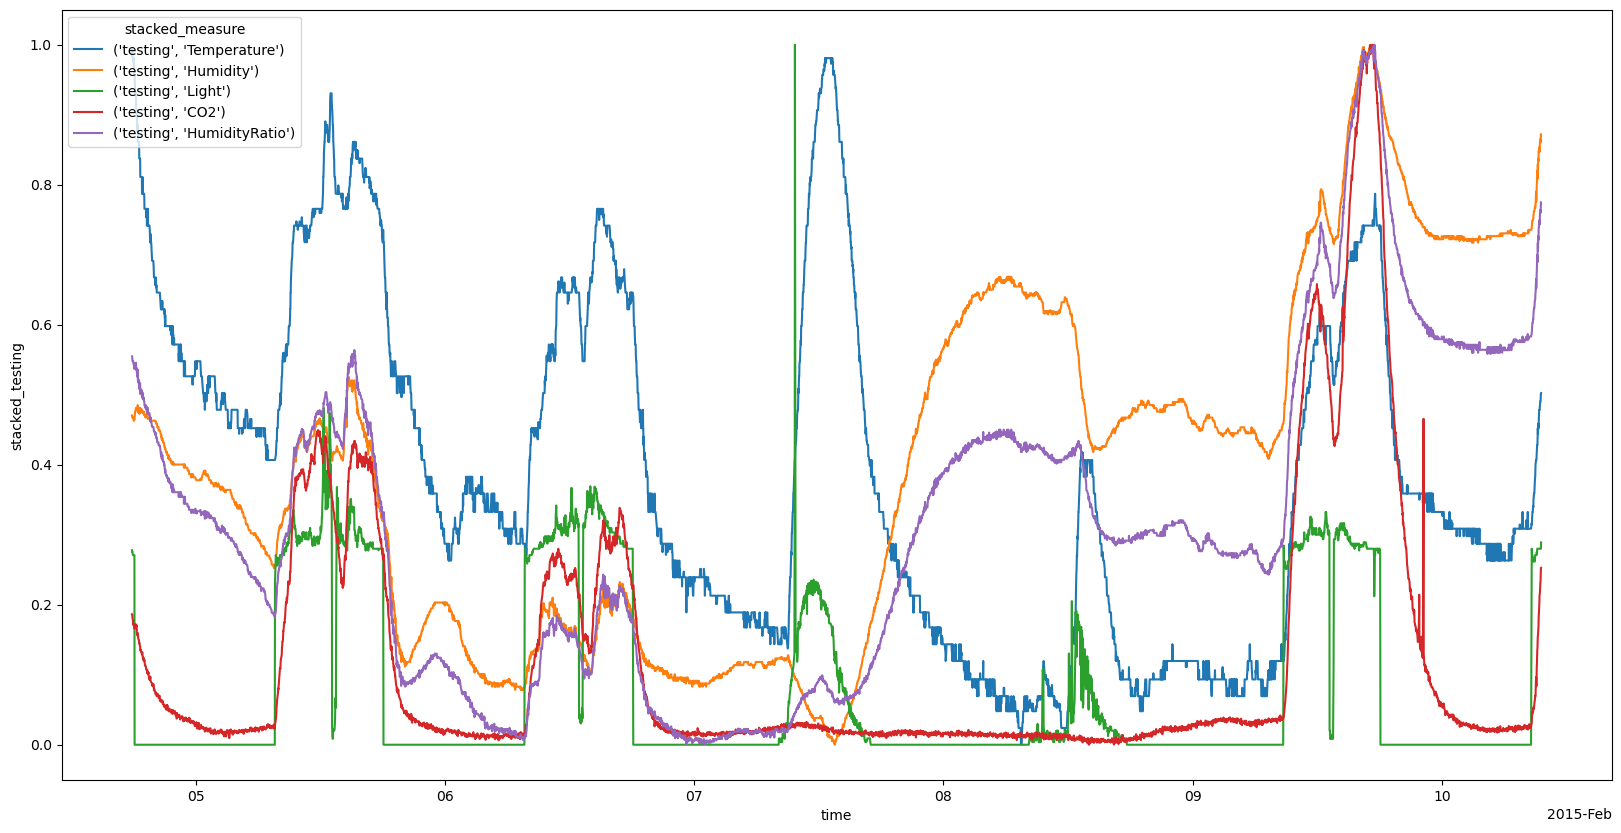

In [306]:
train_dataArray.plot.line(x='time',figsize=(20, 10))
test_dataArray.plot.line(x='time',figsize=(20, 10))

In [439]:
#merge time_occupancy occupancy values into train_dataArray based on the time dimension
'''train_dataArray.coords['Occupancy'] = time_occupancy.sel(measure='Occupancy').drop_vars('measure')
test_dataArray.coords['Occupancy'] = time_occupancy.sel(measure='Occupancy').drop_vars('measure')
train_dataArray.coords['float_time'] = time_occupancy.sel(measure='time_float').drop_vars('measure')
test_dataArray.coords['float_time'] = time_occupancy.sel(measure='time_float').drop_vars('measure')
display(long_time_occupancy_train)
measure_uniques[long_time_occupancy_train['measure_codes'].values.tolist()]
'''

train_data.time.values

array(['2015-02-04T19:00:00.000000000', '2015-02-05T06:00:00.000000000',
       '2015-02-05T09:00:00.000000000', '2015-02-05T10:00:00.000000000',
       '2015-02-05T12:00:00.000000000', '2015-02-05T13:00:00.000000000',
       '2015-02-05T17:00:00.000000000', '2015-02-05T18:00:00.000000000',
       '2015-02-06T00:00:00.000000000', '2015-02-06T01:00:00.000000000',
       '2015-02-06T04:00:00.000000000', '2015-02-06T05:00:00.000000000',
       '2015-02-06T07:00:00.000000000', '2015-02-06T13:00:00.000000000',
       '2015-02-06T14:00:00.000000000', '2015-02-06T15:00:00.000000000',
       '2015-02-06T16:00:00.000000000', '2015-02-06T20:00:00.000000000',
       '2015-02-07T01:00:00.000000000', '2015-02-07T03:00:00.000000000',
       '2015-02-07T05:00:00.000000000', '2015-02-07T13:00:00.000000000',
       '2015-02-07T15:00:00.000000000', '2015-02-07T16:00:00.000000000',
       '2015-02-07T18:00:00.000000000', '2015-02-07T22:00:00.000000000',
       '2015-02-07T23:00:00.000000000', '2015-02-08

# Will a regular gaussian process do the job?


In [460]:
factors = ['time_float', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
n_factors = len(factors)

with pm.Model() as model_gp:
    model_gp.add_coord('time_date', train_data.time.values,mutable=True)
    model_gp.add_coord('measure', factors, mutable=True) #don't include last "occupancy" or time_float
    #model.add_coord('measure_xs', factors, mutable=True)
    #model.add_coord('On_off', ['On_Off'], mutable=False) #don't include last "occupancy" or time_float
    #model.add_coord('rank', np.arange(rank), mutable=True)

    facts = pm.MutableData('facts', train_data.sel(measure=factors).values, dims=['time_date', 'measure'])
    obs = pm.MutableData('obs',train_data.sel(measure='Occupancy').values, dims=['time_date'])
    # Hyperpriors for latent variables
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=1, upper=5, 
        init_guess={"alpha": 2, "beta": 2.0},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    mean_func = pm.gp.mean.Zero()
    cov_func = eta*eta* pm.gp.cov.ExpQuad(input_dim=6, ls=ell, active_dims=[0,1,2,3,4,5])
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    f=gp.prior('f', X=facts)
    occ = pm.Bernoulli('occ', logit_p =f, observed=obs, dims=['time_date'], shape=(obs.eval().shape))

/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 6 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


Compiling...
Compilation time = 0:00:02.587007
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:23.014033
Transforming variables...
Transformation time = 0:00:00.532201


Divergences: 0


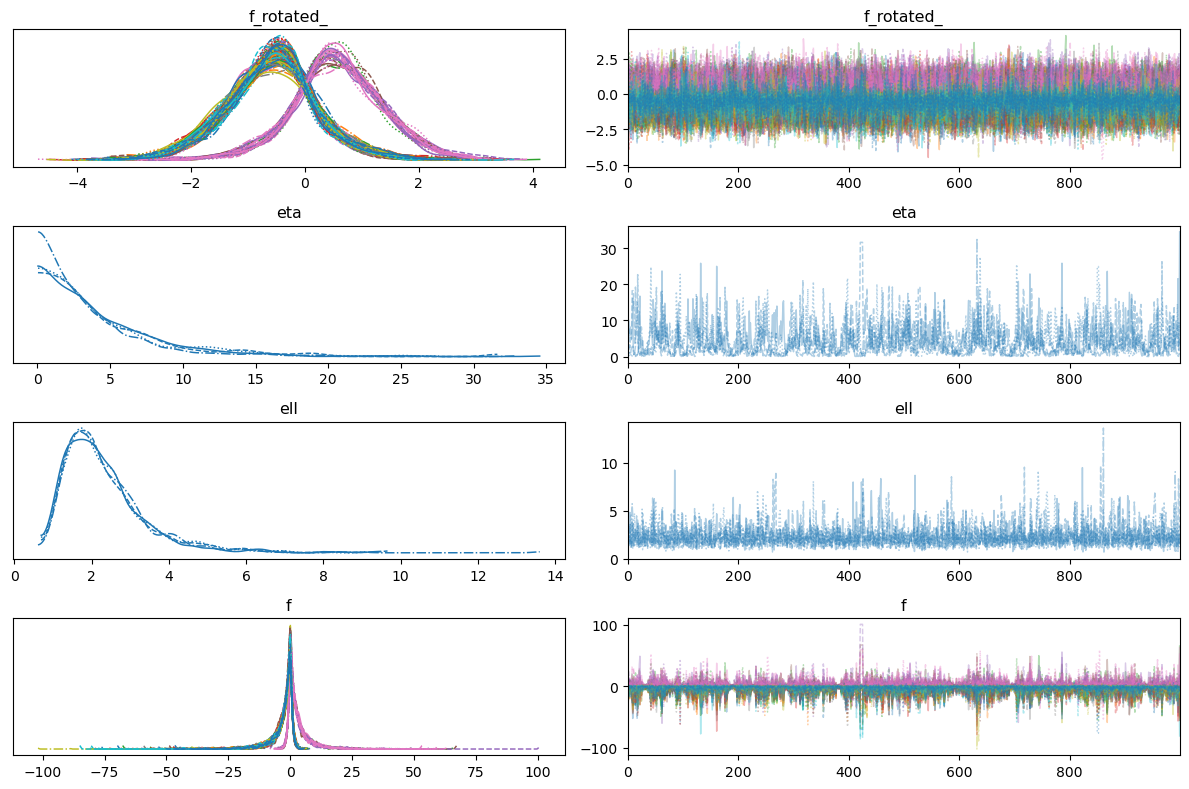

In [461]:
with model_gp:
    samples = sample(model_gp)
    az.plot_trace(samples)
    plt.tight_layout()

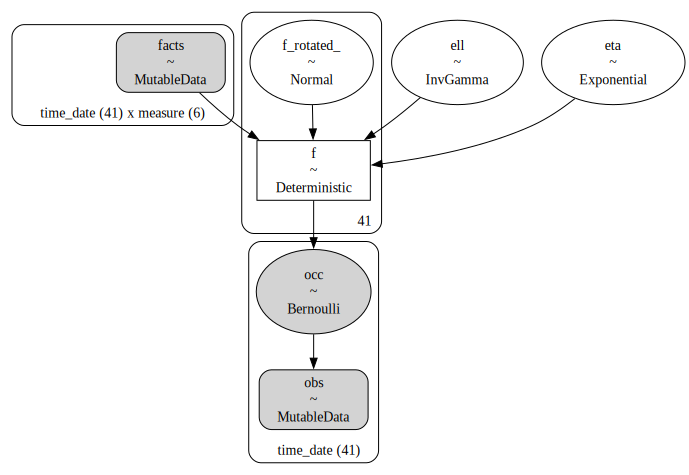

In [462]:
pm.model_to_graphviz(model_gp)

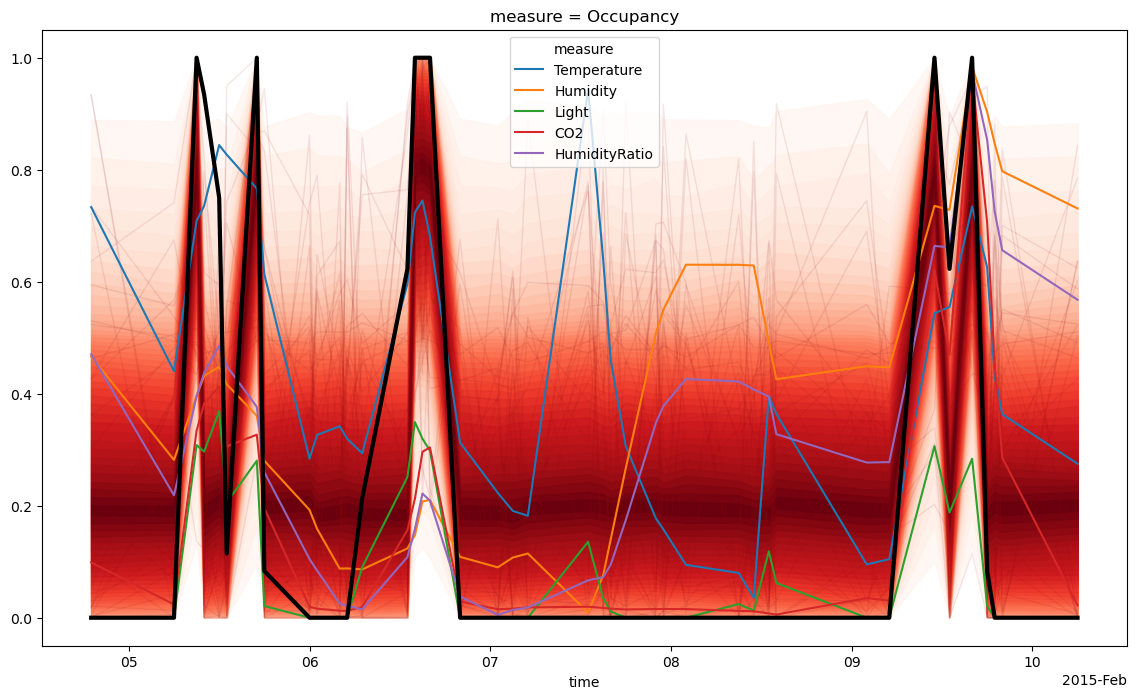

In [463]:


#use arviz to extract the posterior
f_post = az.extract(samples, group="posterior").transpose()
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plot_gp_dist(axes, sigmoid(f_post.f.values), train_dataset.time.values)
train_data.sel(measure=['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']).plot.line(x='time', ax=axes)
#increase the line thickness  of time_data plot
train_data.sel(measure='Occupancy').plot.line(x='time', ax=axes, color='black', linewidth=3)

In [464]:
with model_gp:
    model_gp.set_dim('time_date', new_length=len(test_data.time.values), coord_values=test_data.time.values)
    model_gp.facts.set_value(test_data.sel(measure=factors).values)
    model_gp.obs.set_value(test_data.sel(measure='Occupancy').values)
    gp.conditional('f_new', Xnew=test_data.sel(measure=factors).values)
    gp.predict('occ_new', Xnew=test_data.sel(measure=factors).values)


/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 6 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


In [475]:
occ_new=gp.predict('occ_new', Xnew=test_data.sel(measure='time_float').values[:,None])


TypeError: Base.predict() got multiple values for argument 'Xnew'

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plot_gp_dist(axes, sigmoid(f_post_pred.f_new.values), test_data.time.values)

In [465]:
with model_gp:
    trace_post = pm.sample_posterior_predictive(samples, var_names=["f_new"])

Sampling: [f_new, f_rotated_]


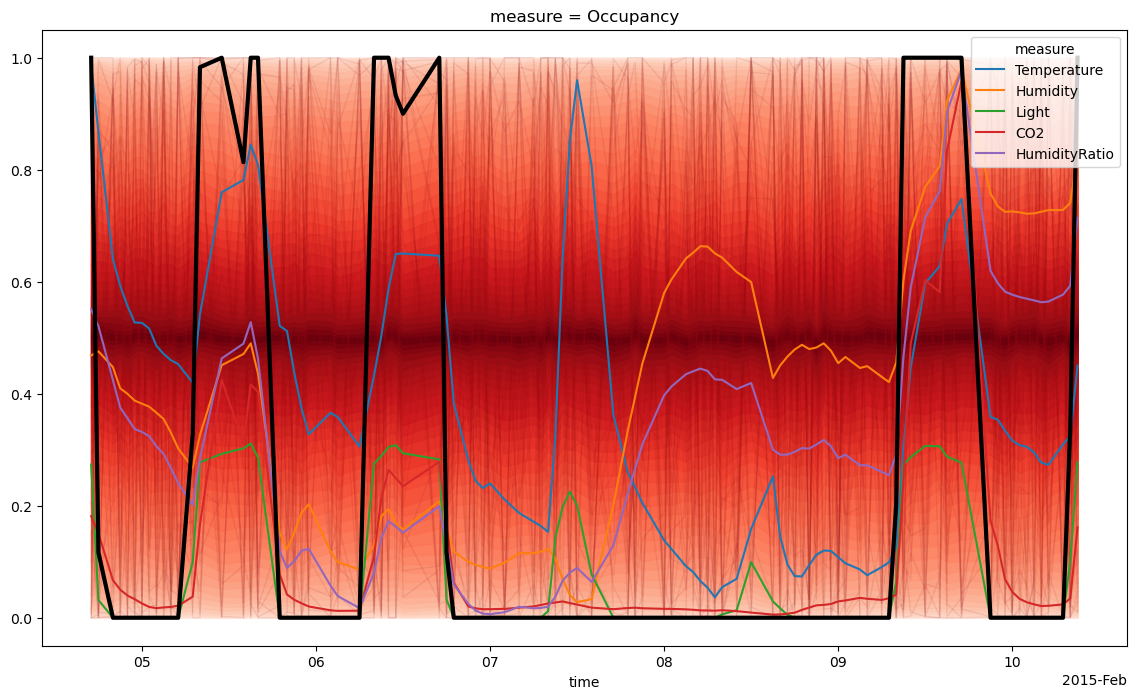

In [466]:
#use arviz to extract the posterior
f_post_pred = az.extract(trace_post, group="posterior_predictive").transpose()
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plot_gp_dist(axes, sigmoid(f_post_pred.f_new.values), test_data.time.values)
test_data.sel(measure=['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']).plot.line(x='time', ax=axes)
#increase the line thickness  of time_data plot
test_data.sel(measure='Occupancy').plot.line(x='time', ax=axes, color='black', linewidth=3)

## ICM

In [429]:
factors = ['time_float', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
n_factors = len(factors)
rank=2

with pm.Model() as model:
    #model.add_coords({key:item.values for key, item in train_data.coords.items()})
    model.add_coord('time', train_data.sel(measure='time_float').values,mutable=True)
    model.add_coord('measure', factors, mutable=True) #don't include last "occupancy" or time_float
    model.add_coord('measure_xs', factors, mutable=True)
    #model.add_coord('On_off', ['On_Off'], mutable=False) #don't include last "occupancy" or time_float
    model.add_coord('rank', np.arange(rank), mutable=True)

    facts = pm.MutableData('facts', train_data.sel(measure=factors).values, dims=['time', 'measure'])
    obs = pm.MutableData('obs',train_data.sel(measure='Occupancy').values, dims=['time'])

    # Hyperpriors for latent variables
        # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=.0020, upper=.0200, 
        init_guess={"alpha": .02, "beta": .020},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    mean_func = pm.gp.mean.Zero()
    kernel = eta*eta* pm.gp.cov.ExpQuad(input_dim=6, ls=ell, active_dims=[0])
    #cov_func *= 
    #need to work the multiple facts into the gp
    W = pm.Normal("W", mu=0, sigma=1, dims=('measure', 'rank'))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, dims=('measure'))
    B = pm.Deterministic("B", pm.math.dot(W, W.T) + pt.diag(kappa), 
                         dims=('measure','measure_xs'))
    coregion = pm.gp.cov.Coregion(input_dim=6, B=B, active_dims=[0])
    cov_icm =  kernel * coregion

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_icm)

    sigma = pm.HalfNormal("sigma", sigma=1)
    f=gp.prior('f', X=facts)
    occ = pm.Bernoulli('occ', logit_p =f, observed=obs, dims=['time'], shape=(obs.eval().shape))
'''    
    y_ = gp.marginal_likelihood("f_y", facts, obs, sigma=sigma)

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_icm)
    #gp = pm.gp.HSGP(m=[50]*5, c=1.3, cov_func=cov_func) $6 factors is too big for hsgp
    #f = gp.marginal_likelihood("f", X=facts, y=obs, noise=0.1)
    f=gp.prior('f', X= facts)

    #           np.arange(len(train_data.sel(dict(measure='time_float')).values))[:,None]
    
    #train_data.sel(dict(measure='time_float')).values[:,None],  dims=['time','measure'])
    lin_f_coef = pm.Normal('lin_f_coef', mu=0, sigma=1, dims=('measure'))
    lin_f = pm.Deterministic('lin_f', pm.math.dot(lin_f_coef.T,f.T))
    
    #, shape=(obs.eval().shape[0]),dims=['time'])#,
    #observed=np.repeat(obs.eval()[:,None], 5, axis=1)                    
    #shape=(obs.eval().shape, 5), dims=['time', 'measures'])
   '''

/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 6 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


'    \n    y_ = gp.marginal_likelihood("f_y", facts, obs, sigma=sigma)\n\n    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_icm)\n    #gp = pm.gp.HSGP(m=[50]*5, c=1.3, cov_func=cov_func) $6 factors is too big for hsgp\n    #f = gp.marginal_likelihood("f", X=facts, y=obs, noise=0.1)\n    f=gp.prior(\'f\', X= facts)\n\n    #           np.arange(len(train_data.sel(dict(measure=\'time_float\')).values))[:,None]\n    \n    #train_data.sel(dict(measure=\'time_float\')).values[:,None],  dims=[\'time\',\'measure\'])\n    lin_f_coef = pm.Normal(\'lin_f_coef\', mu=0, sigma=1, dims=(\'measure\'))\n    lin_f = pm.Deterministic(\'lin_f\', pm.math.dot(lin_f_coef.T,f.T))\n    \n    #, shape=(obs.eval().shape[0]),dims=[\'time\'])#,\n    #observed=np.repeat(obs.eval()[:,None], 5, axis=1)                    \n    #shape=(obs.eval().shape, 5), dims=[\'time\', \'measures\'])\n   '

In [430]:
with model:
    idata_prior_pred = pm.sample_prior_predictive(100)
display(idata_prior_pred)

Sampling: [W, ell, eta, f_rotated_, kappa, occ, sigma]


IndexError: index 99 is out of bounds for axis 0 with size 6
Apply node that caused the error: AdvancedSubtensor(B, Cast{int32}.0, Transpose{axes=[1, 0]}.0)
Toposort index: 28
Inputs types: [TensorType(float64, shape=(None, None)), TensorType(int32, shape=(None, 1)), TensorType(int32, shape=(1, None))]
Inputs shapes: [(6, 6), (41, 1), (1, 41)]
Inputs strides: [(48, 8), (4, 4), (4, 4)]
Inputs values: ['not shown', 'not shown', 'not shown']
Outputs clients: [[Composite{((exp((-0.5 * clip((i3 + i4 + i5), 0.0, inf))) * i1 * i1 * i2) + (1e-06 * i0))}(Eye{dtype='float64'}.0, ExpandDims{axes=[0, 1]}.0, AdvancedSubtensor.0, Dot22Scalar.0, ExpandDims{axis=1}.0, ExpandDims{axis=0}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2581/3723433729.py", line 41, in <module>
    f=gp.prior('f', X=facts)
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/gp.py", line 192, in prior
    f = self._build_prior(name, X, reparameterize, jitter, **kwargs)
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/gp.py", line 153, in _build_prior
    cov = stabilize(self.cov_func(X), jitter)
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py", line 335, in __call__
    return reduce(mul, self._merge_factors_cov(X, Xs, diag))
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py", line 247, in _merge_factors_cov
    factor_list.append(factor(X, Xs, diag))
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py", line 83, in __call__
    return self.full(X, Xs)
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py", line 1162, in full
    return self.B[index, index2]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [388]:
#create a function for calculating the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [389]:
import arviz as az
f_pri = az.extract(idata_prior_pred, group="prior").transpose()
display(sigmoid(f_pri.f))
f_pri

<xarray.DataArray 'f' (sample: 100, f_dim_0: 41)>
array([[8.01843758e-01, 1.08499954e-04, 6.27240841e-04, ...,
        3.81536672e-02, 1.47434406e-02, 3.10810308e-01],
       [5.62759341e-03, 6.91168683e-01, 9.99999993e-01, ...,
        4.17839758e-02, 6.42605281e-01, 6.58640353e-09],
       [8.02118737e-01, 8.51318201e-01, 5.42834865e-02, ...,
        3.33533822e-01, 4.83047548e-01, 7.11230384e-02],
       ...,
       [6.52097037e-01, 4.87780880e-01, 4.60106838e-01, ...,
        5.36399774e-01, 5.79309360e-01, 5.57670396e-01],
       [3.99892702e-01, 4.58620309e-01, 4.63298457e-01, ...,
        4.71661206e-01, 4.67892153e-01, 5.74441475e-01],
       [9.99999845e-01, 8.27537456e-01, 3.84135781e-02, ...,
        2.87193611e-03, 9.97474160e-01, 9.98785650e-01]])
Coordinates:
  * f_dim_0  (f_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

<xarray.Dataset>
Dimensions:           (measure: 6, rank: 2, sample: 100, measure_xs: 6,
                       f_rotated__dim_0: 41, f_dim_0: 41)
Coordinates:
  * measure           (measure) <U13 'time_float' ... 'HumidityRatio'
  * rank              (rank) int64 0 1
  * measure_xs        (measure_xs) <U13 'time_float' ... 'HumidityRatio'
  * f_rotated__dim_0  (f_rotated__dim_0) int64 0 1 2 3 4 5 ... 35 36 37 38 39 40
  * f_dim_0           (f_dim_0) int64 0 1 2 3 4 5 6 7 ... 34 35 36 37 38 39 40
  * sample            (sample) object MultiIndex
  * chain             (sample) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw              (sample) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
Data variables:
    W                 (sample, rank, measure) float64 0.6946 0.6857 ... -1.087
    sigma             (sample) float64 0.7434 1.649 0.7293 ... 0.4143 0.5738
    B                 (sample, measure_xs, measure) float64 5.254 ... 3.842
    eta               (sample) float64 1.69 9.369 1.454 ... 0.1823 0.1208 3.101
    f_rotated_        (sample, f_rotated__dim_0) float64 0.3608 ... 0.8716
    kappa             (sample, measure) float64 4.746 1.244 ... 4.857 2.643
    ell               (sample) float64 0.008401 0.007435 ... 0.007835 0.00792
    f                 (sample, f_dim_0) float64 1.398 -9.129 ... 5.979 6.712
Attributes:
    created_at:                 2024-01-18T07:37:46.589736
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.3

<Axes: >

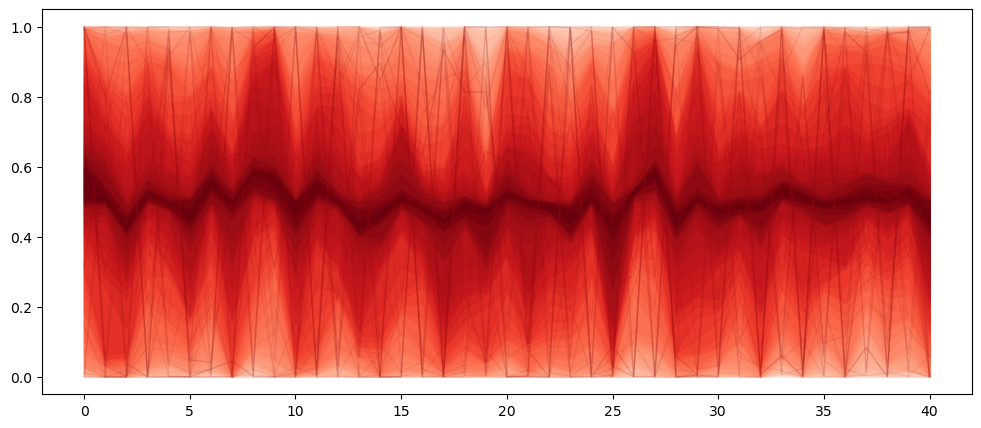

In [390]:
#plot the gp prior
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax=ax, samples = sigmoid(f_pri.f.values), x=f_pri.f_dim_0.values, plot_samples=True)
#train_data.sel(measure='Occupancy').plot.line(x='time_float', ax=ax, color='black', linewidth=3)
 

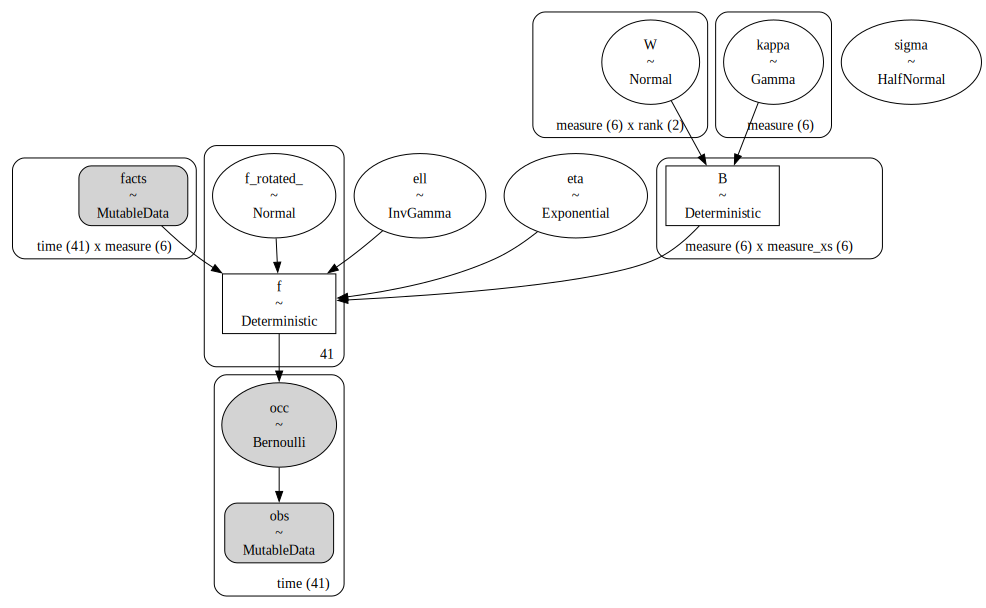

In [391]:
pm.model_to_graphviz(model)
                    

Compiling...
/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/sampling/jax.py:454: UserWarning:BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
Compilation time = 0:00:02.554964
Sampling...
Sampling time = 0:00:38.705602
Transforming variables...
Transformation time = 0:00:00.820358


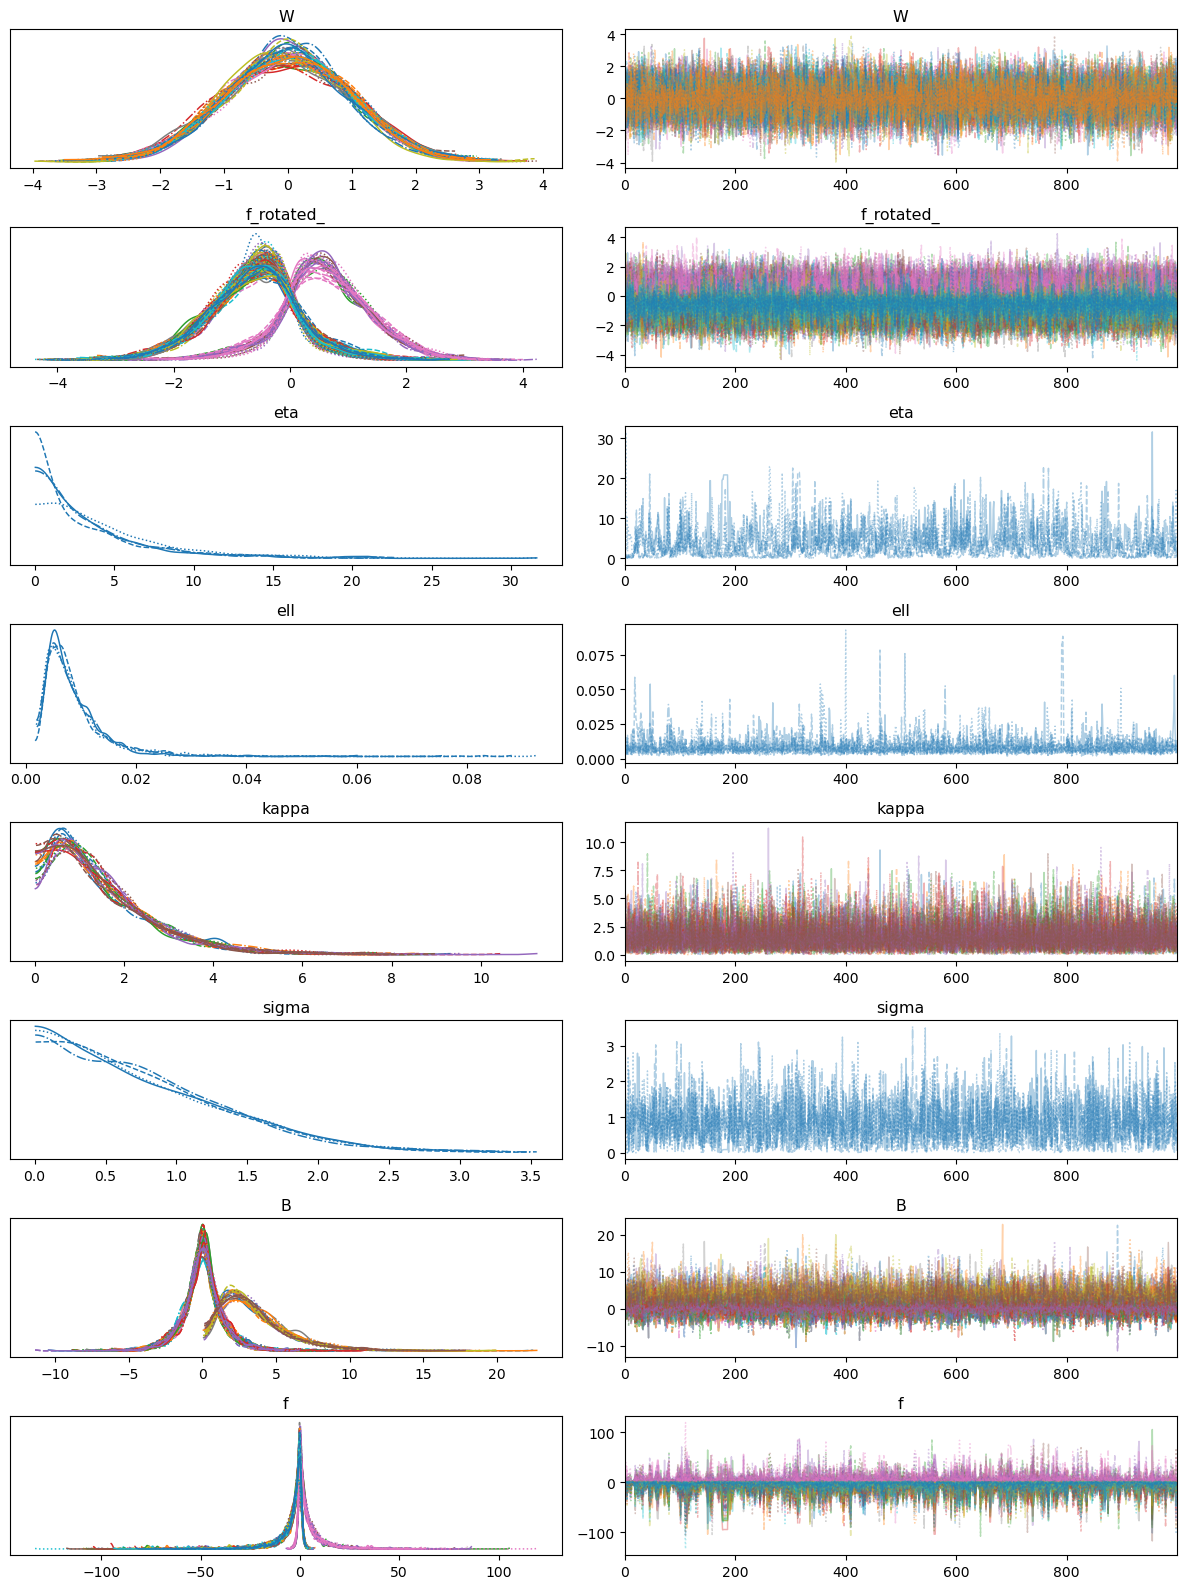

In [392]:
with model:
    
    trace = pm.sample(1000, tune=1000, cores=4, nuts_sampler='blackjax')
    pm.plot_trace(trace)
    plt.tight_layout()
    pm.summary(trace)
    


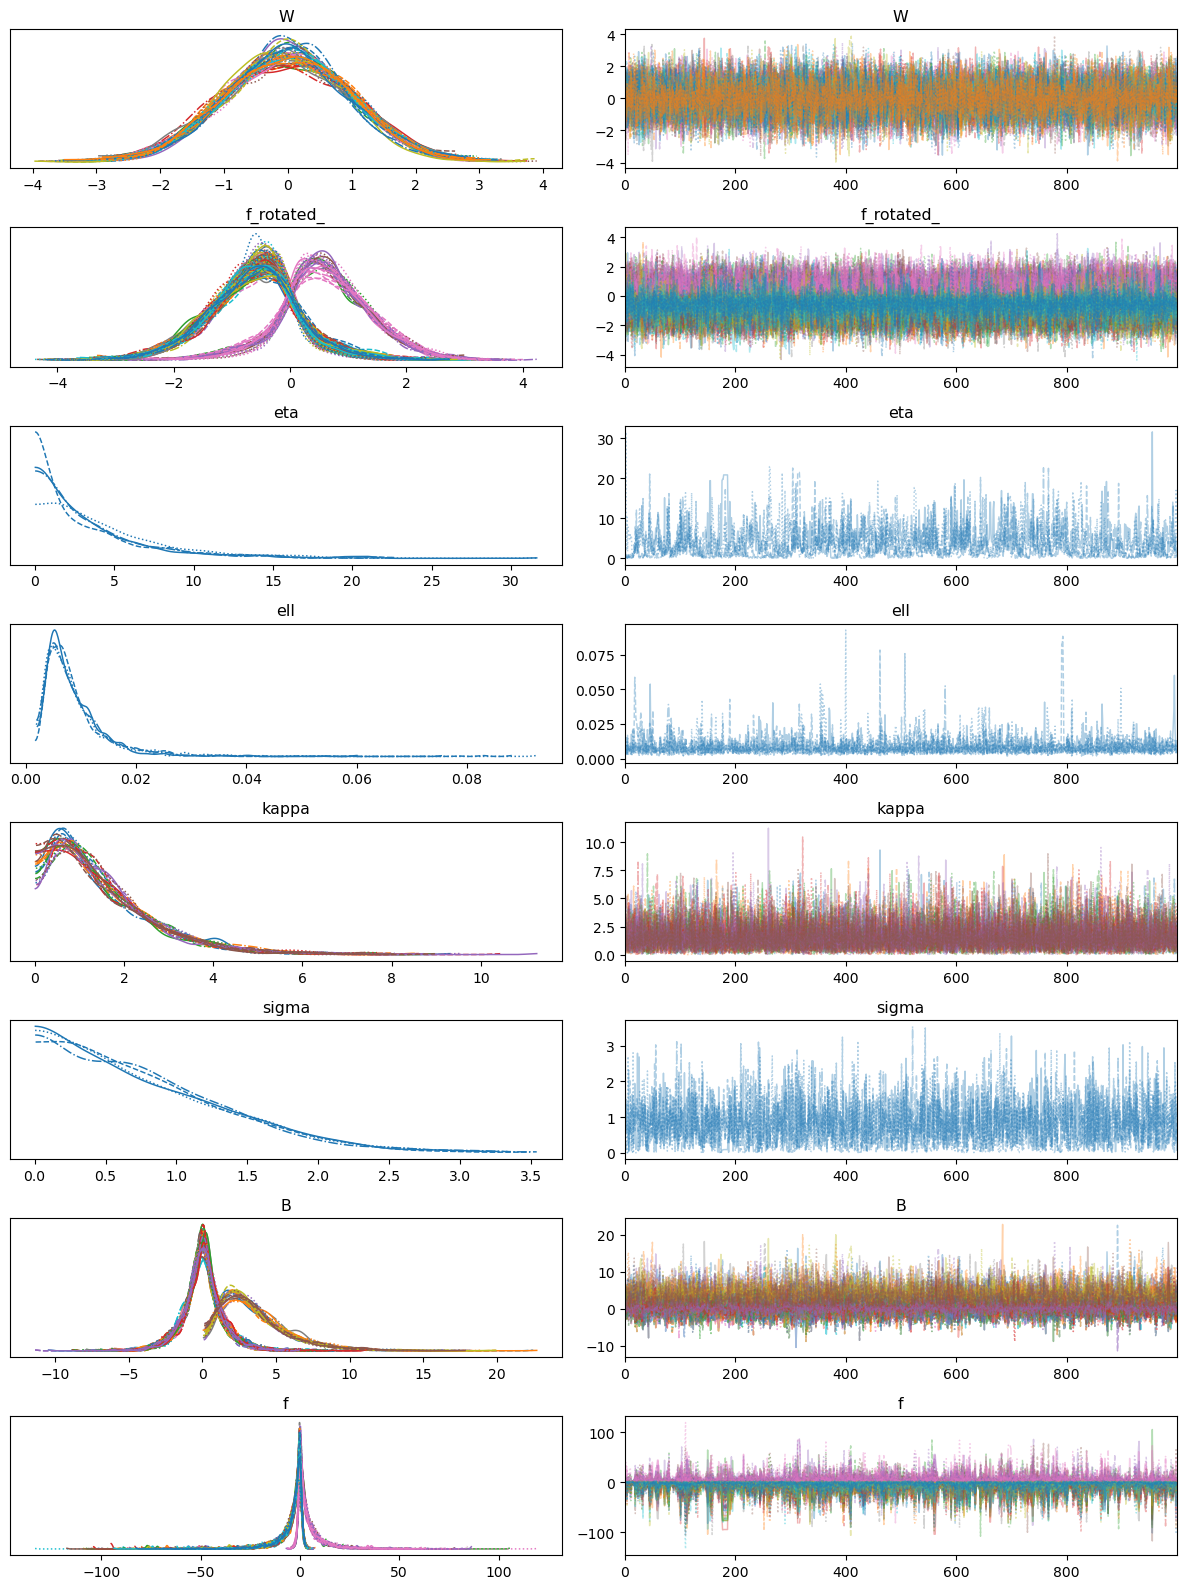

In [393]:
with model:
    pm.plot_trace(trace)
    plt.tight_layout()

In [394]:
'''#plot posterior extracted via arviz from trace
post = trace.posterior
obs_env_train = trace.constant_data.facts[0,:]
obs_times = trace.constant_data.time
fig, ax = plt.subplots(figsize=(12, 5))
ax = plt.plot(obs_times, post["f"][0,:,:].T, "C1", alpha=0.1)
ax = plt.plot(obs_times, post["f"][0,:,:].mean(axis=1), "C1", alpha=0.5)

#plot_gp_dist(ax, post["f"][0,:,:], obs_times.values)'''

'#plot posterior extracted via arviz from trace\npost = trace.posterior\nobs_env_train = trace.constant_data.facts[0,:]\nobs_times = trace.constant_data.time\nfig, ax = plt.subplots(figsize=(12, 5))\nax = plt.plot(obs_times, post["f"][0,:,:].T, "C1", alpha=0.1)\nax = plt.plot(obs_times, post["f"][0,:,:].mean(axis=1), "C1", alpha=0.5)\n\n#plot_gp_dist(ax, post["f"][0,:,:], obs_times.values)'

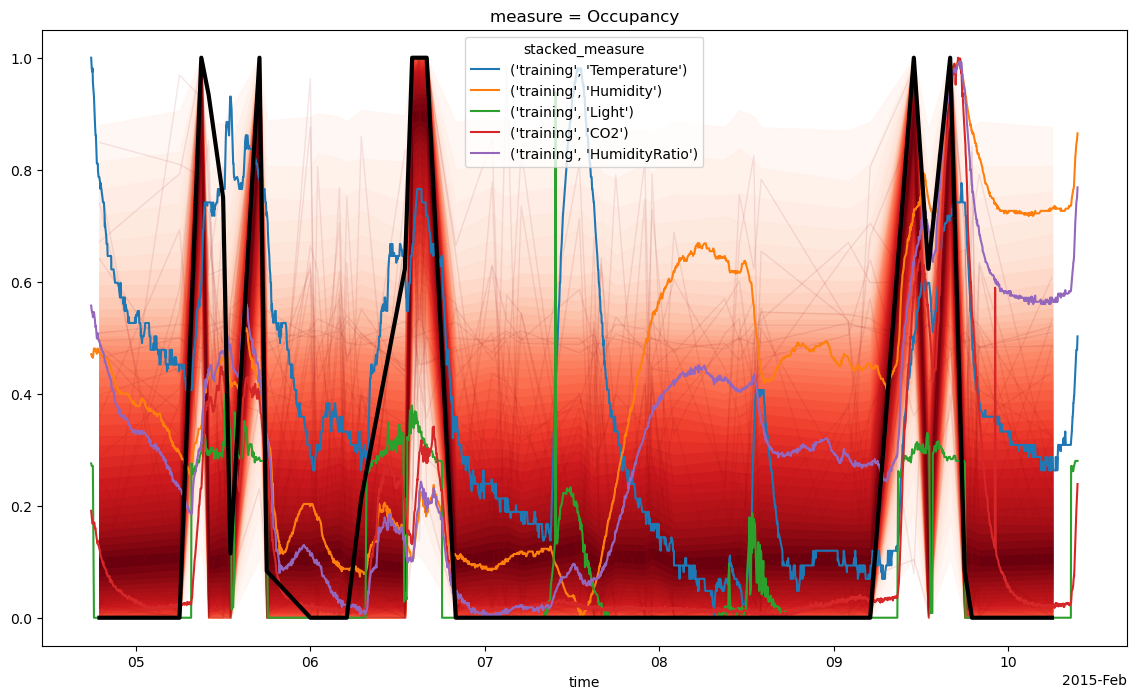

In [395]:


#use arviz to extract the posterior
f_post = az.extract(trace, group="posterior").transpose()
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plot_gp_dist(axes, sigmoid(f_post.f.values), train_dataset.time.values)
train_dataArray.plot.line(x='time', ax=axes)
#increase the line thickness  of time_data plot
train_data.sel(measure='Occupancy').plot.line(x='time', ax=axes, color='black', linewidth=3)

In [396]:
test_data

<xarray.DataArray (time: 96, measure: 7)>
array([[1.00000000e+00, 9.86975013e-01, 4.68231087e-01, 2.73729971e-01,
        1.81391511e-01, 5.50756543e-01, 4.00000000e+00],
       [1.16666667e-01, 8.67590377e-01, 4.75730373e-01, 3.16070274e-02,
        1.50380800e-01, 5.20778209e-01, 3.85000000e+01],
       [0.00000000e+00, 6.40377909e-01, 4.47450809e-01, 0.00000000e+00,
        6.70264723e-02, 4.24561983e-01, 1.59000000e+02],
       [0.00000000e+00, 5.93045587e-01, 4.09730448e-01, 0.00000000e+00,
        5.01616037e-02, 3.75493613e-01, 2.18500000e+02],
       [0.00000000e+00, 5.56978325e-01, 3.99938449e-01, 0.00000000e+00,
        3.96861834e-02, 3.56399632e-01, 2.79000000e+02],
       [0.00000000e+00, 5.27147028e-01, 3.87650547e-01, 0.00000000e+00,
        3.31133064e-02, 3.36940997e-01, 3.39000000e+02],
       [0.00000000e+00, 5.26508506e-01, 3.82240101e-01, 0.00000000e+00,
        2.54508570e-02, 3.31775346e-01, 3.98500000e+02],
       [0.00000000e+00, 5.16445734e-01, 3.76854391e-01, 0.00000000e+00,
        1.92977428e-02, 3.24147056e-01, 4.59000000e+02],
       [0.00000000e+00, 4.85564837e-01, 3.66103463e-01, 0.00000000e+00,
        1.70645421e-02, 3.06186159e-01, 5.19000000e+02],
       [0.00000000e+00, 4.70866560e-01, 3.54770862e-01, 0.00000000e+00,
        1.83781182e-02, 2.92057768e-01, 5.78500000e+02],
...
       [0.00000000e+00, 3.34320006e-01, 7.24832431e-01, 0.00000000e+00,
        6.89505057e-02, 5.82296406e-01, 7.53900000e+03],
       [0.00000000e+00, 3.16188198e-01, 7.25543512e-01, 0.00000000e+00,
        4.61197930e-02, 5.76867228e-01, 7.59850000e+03],
       [0.00000000e+00, 3.08213716e-01, 7.23846789e-01, 0.00000000e+00,
        3.38547546e-02, 5.72728015e-01, 7.65900000e+03],
       [0.00000000e+00, 3.05328035e-01, 7.21455479e-01, 0.00000000e+00,
        2.76121967e-02, 5.69684779e-01, 7.71900000e+03],
       [0.00000000e+00, 2.95125598e-01, 7.21895060e-01, 0.00000000e+00,
        2.39345333e-02, 5.66691205e-01, 7.77850000e+03],
       [0.00000000e+00, 2.77015191e-01, 7.24949578e-01, 0.00000000e+00,
        2.09194160e-02, 5.63355163e-01, 7.83900000e+03],
       [0.00000000e+00, 2.72957046e-01, 7.27959378e-01, 0.00000000e+00,
        2.13190950e-02, 5.64622735e-01, 7.89900000e+03],
       [0.00000000e+00, 3.09743248e-01, 7.28149862e-01, 0.00000000e+00,
        2.38203342e-02, 5.76996845e-01, 8.01900000e+03],
       [3.38983051e-01, 3.24014003e-01, 7.40833335e-01, 1.01965283e-01,
        3.44866170e-02, 5.92969369e-01, 8.07900000e+03],
       [1.00000000e+00, 4.50133103e-01, 8.26303848e-01, 2.77687255e-01,
        1.61289907e-01, 7.13914414e-01, 8.12550000e+03]])
Coordinates:
  * measure     (measure) <U13 'Occupancy' 'Temperature' ... 'time_float'
  * time        (time) datetime64[ns] 2015-02-04T17:00:00 ... 2015-02-10T09:0...
    train_test  (time) <U5 'Test' 'Test' 'Test' 'Test' ... 'Test' 'Test' 'Test'

In [402]:
with model:
    model.facts.set_value(test_data.sel(measure=factors).values)
    model.obs.set_value(test_data.sel(measure='Occupancy').values)
    gp.conditional('f_new', Xnew=test_data.sel(measure=factors).values)
    model.set_dim('time', new_length=len(test_data.sel(measure='time_float').values), coord_values=test_data.sel(measure='time_float').values)


/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 6 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


In [403]:

with model:
    trace_post = pm.sample_posterior_predictive(trace, var_names=["f_new"])



Sampling: [f_new2, f_rotated_]


In [415]:
sigmoid(temp.eval().T)

array([0.55708895, 0.05474701, 0.92848169, 0.03553788, 0.30195857,
       0.85506992, 0.64878154, 0.70437125, 0.83149654, 0.36673718,
       0.63884676, 0.70832295, 0.39239479, 0.27327256, 0.31932394,
       0.81183649, 0.24275515, 0.40261693, 0.67865921, 0.30541723,
       0.28582824, 0.93957136, 0.20726182, 0.82506113, 0.75425791,
       0.41313291, 0.74500239, 0.93224646, 0.33212857, 0.65888277,
       0.039553  , 0.37109114, 0.93842011, 0.5786109 , 0.90301264,
       0.02957896, 0.55445385, 0.33208112, 0.87170097, 0.08558151,
       0.13773651, 0.73271062, 0.86444622, 0.27127763, 0.21539059,
       0.33990689, 0.36618257, 0.28442482, 0.96127246, 0.58004116,
       0.75218547, 0.06934593, 0.53574069, 0.47132839, 0.63367043,
       0.81376941, 0.19625455, 0.68178119, 0.13165979, 0.58166448,
       0.71278118, 0.97793308, 0.12091644, 0.69186309, 0.11996472,
       0.07743851, 0.24125828, 0.48557068, 0.13344001, 0.05960759,
       0.1564105 , 0.92093987, 0.08243535, 0.55862194, 0.77103

ValueError: x and y must have same first dimension, but have shapes (137,) and (1, 30)

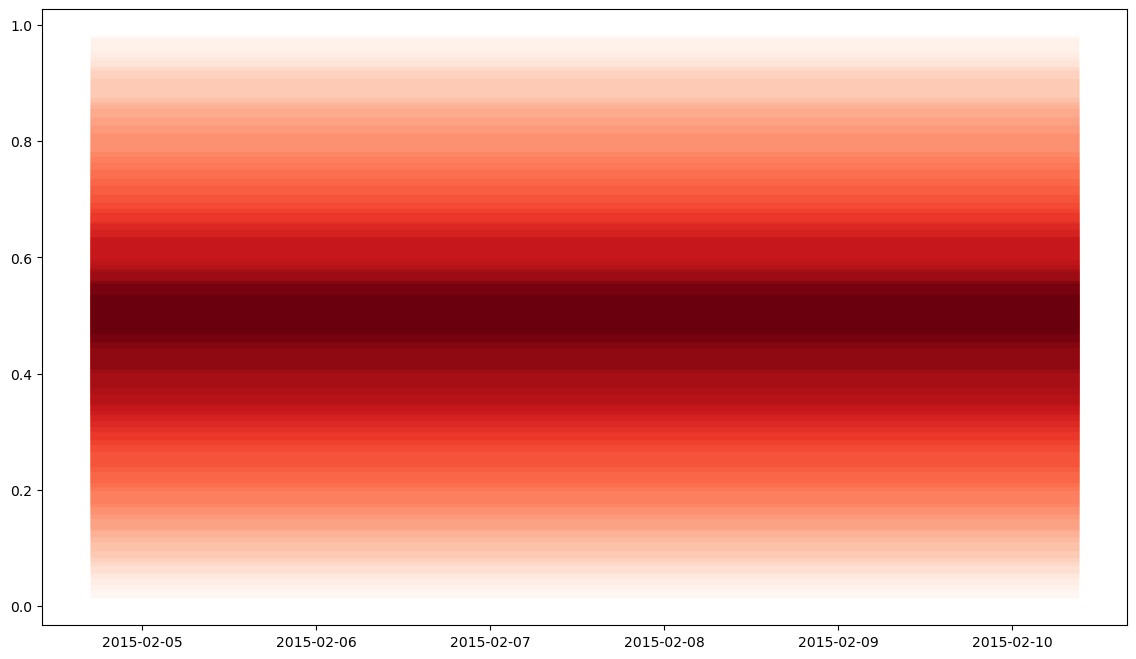

In [416]:
# replace the data and coords in model with the data drom test_data and run posterior predictive

#use arviz to extract the posterior predictive
f_post_pred = az.extract(trace_post, group="posterior_predictive").transpose()
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plot_gp_dist(axes, sigmoid(f_post_pred.f_new.values), test_dataset.time.values)
test_dataArray.plot.line(x='time', ax=axes)
#increase the line thickness  of time_data plot
test_data.sel(measure='Occupancy').plot.line(x='time', ax=axes, color='black', linewidth=3)

In [400]:
trace_post

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data